In [1]:
import pandas as pd
import numpy as np

# Tools for recursive feature selection
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

# Tools for fitting logistic regression and getting p-values
import statsmodels.api as sm

# For plotting
import matplotlib.pyplot as plt

# Our local, useful function for preparing the merged dataframe for modeling
from baseball_utils import prepare_df

## Use recursive feature selection to rank the features

In [2]:
# Load the dataframe
cp_df = pd.read_csv("cp_merged.csv")

In [3]:
%time X, y = prepare_df(cp_df)

/Users/robertair2019/Desktop/upm/baseball_utils.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['strike_given_called'] = df['strike_given_called'].apply(int)
/Users/robertair2019/Desktop/upm/baseball_utils.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['upm'] = df.apply(lambda x: x.pitcher_race==x.umpire_race, axis=1).apply(int)


CPU times: user 37.1 s, sys: 408 ms, total: 37.5 s
Wall time: 36.9 s


In [17]:
%time rfe = RFE(LogisticRegression(solver="liblinear"),1).fit(X, y)

CPU times: user 44.6 s, sys: 3.29 s, total: 47.9 s
Wall time: 39.9 s


In [19]:
# The ranking position of the ith feature
print(rfe.ranking_)

[23 18 21  6  1 10  7  2 19  8  3  4  9  5 22 20 12 14 11 13 15 17 16]


In [32]:
# The features themselves
print(X.columns)

Index(['upm', 'home_pitcher', 'run_diff', 'count_0-1', 'count_0-2',
       'count_1-0', 'count_1-1', 'count_1-2', 'count_2-0', 'count_2-1',
       'count_2-2', 'count_3-0', 'count_3-1', 'count_3-2', 'inning_2',
       'inning_3', 'inning_4', 'inning_5', 'inning_6', 'inning_7', 'inning_8',
       'inning_9+', 'intercept'],
      dtype='object')


## Here we have ranked the features in order of significance:
* Notice that UPM appears lowest in the order of significance.
* This does not necessarily indicate that there is no effect, but rather, that the effect is subtle. In order to illustrate the importance of the control variables, we eliminate the non-UPM features one by one from the model, in order of increasing significance, and compare the UPM coefficient and corresponding p-value to the number of model features.

In [53]:
ranked_features = [X.columns.tolist()[np.where(rfe.ranking_ == i)[0][0]] for i in range(1,len(X.columns)+1)]

In [54]:
ranked_features.remove('intercept')

In [55]:
for i, f in enumerate(ranked_features):
    print(f"{i+1}. {f}")

1. count_0-2
2. count_1-2
3. count_2-2
4. count_3-0
5. count_3-2
6. count_0-1
7. count_1-1
8. count_2-1
9. count_3-1
10. count_1-0
11. inning_6
12. inning_4
13. inning_7
14. inning_5
15. inning_8
16. inning_9+
17. home_pitcher
18. count_2-0
19. inning_3
20. run_diff
21. inning_2
22. upm


## We eliminate the features one-by-one and calculate UPM coefficients and p-values for the corresponding models

In [58]:
# Get the ranked features
rf = ranked_features[:-1]

# Initialize the p-values
p = []

# Initialize the coefficients
beta = []

# Initialize the list of number-of-features
nfeatures = []

In [59]:
while (rf):
    nfeatures.append(len(rf)+1)
    print(f"Fitting {nfeatures[-1]} variables...")
    fit = sm.Logit(y,X[['upm', 'intercept'] + rf]).fit()
    beta.append(fit.params[0])
    p.append(fit.pvalues[0])
    print(f"Beta = {beta[-1]}; p = {p[-1]}")
    rf = rf[:-1]

Fitting 22 variables...
Optimization terminated successfully.
         Current function value: 0.580795
         Iterations 6
Beta = 0.0051387482643888574; p = 0.23900622040607855
Fitting 21 variables...
Optimization terminated successfully.
         Current function value: 0.580797
         Iterations 6
Beta = 0.005152675106252487; p = 0.2377343267982288
Fitting 20 variables...
Optimization terminated successfully.
         Current function value: 0.580995
         Iterations 6
Beta = 0.005331898719088635; p = 0.2217071971083846
Fitting 19 variables...
Optimization terminated successfully.
         Current function value: 0.581000
         Iterations 6
Beta = 0.0053208986178373986; p = 0.22265898791676864
Fitting 18 variables...
Optimization terminated successfully.
         Current function value: 0.581006
         Iterations 6
Beta = 0.005289272828990819; p = 0.2254160157908779
Fitting 17 variables...
Optimization terminated successfully.
         Current function value: 0.581044
  

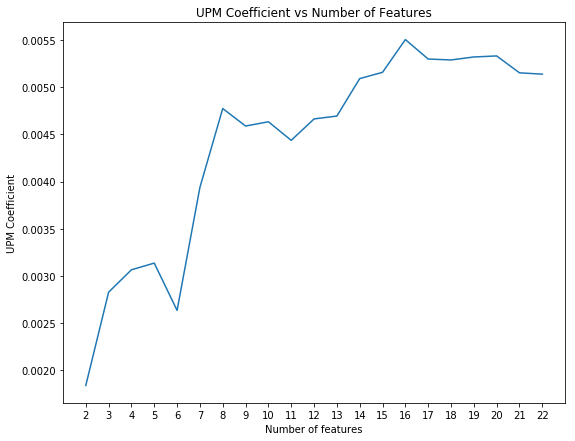

In [77]:
plt.figure(figsize=(9,7))
plt.plot(nfeatures, beta)
plt.xlabel("Number of features")
plt.ylabel("UPM Coefficient")
plt.xticks(nfeatures)
plt.title("UPM Coefficient vs Number of Features")
plt.savefig("upm_vs_nfeatures_all.png")
plt.show()

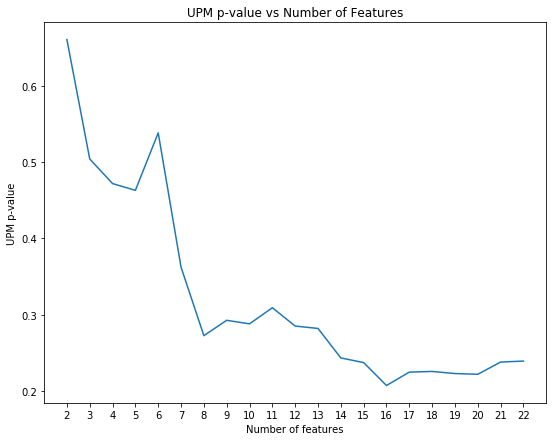

In [78]:
plt.figure(figsize=(9,7))
plt.plot(nfeatures, p)
plt.xlabel("Number of features")
plt.ylabel("UPM p-value")
plt.title("UPM p-value vs Number of Features")
plt.xticks(nfeatures)
plt.savefig("pval_vs_nfeatures_all.png")